## Modeling

---

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
pd.options.display.max_colwidth = 400

In [2]:
subreddit = pd.read_csv('../datasets/subreddit_combined.csv')

In [3]:
subreddit.head(2)

,link_flair_text,over_18,selftext,subreddit,title
0,Other,False,So in the venom 2 post credit venom says he recognizes peter Parker even though that venom has never met him because almost the moment venom arrived on earth he has been with Eddie or in a secret facility so could they have met in between movies?,Marvel,plot hole
1,Film/Television,False,"Alright, so I avoided this movie until today, what’s that like 12 years, because if the reviews and I gotta say, it was actually pretty good. Way better than the second Venom, let there be Carnage. \n\nForget other peoples opinions. Watch what you want.",Marvel,"Green lantern, not that bad."


In [4]:
X = subreddit[['selftext', 'title']]
y = subreddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55, stratify=y)

### Generating a Baseline Model

#### Since r/harrypotter is the majority class, it is the positive class (the one we're predicting)

In [5]:
y.value_counts(normalize=True)

harrypotter    0.636354
Marvel         0.363646
Name: subreddit, dtype: float64

### Making First Logistic Regression Model with Count Vectorizer

In [11]:
ct1 = make_column_transformer((CountVectorizer(), 'selftext'), (CountVectorizer(), 'title'))

pipe1 = make_pipeline(ct1, LogisticRegression(max_iter=10_000))

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

(1.0, 0.9604166666666667)

##### Added stop words and "min_df" parameters to pipeline to test

In [49]:
ct2 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2), 'title')
)

pipe2 = make_pipeline(ct2, LogisticRegression(max_iter=10_000))

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.9995833333333334, 0.9704166666666667)

In [50]:
f1_score(y_test, pipe2.predict(X_test), pos_label='harrypotter')

0.9768804949527842

In [51]:
balanced_accuracy_score(y_test, pipe2.predict(X_test))

0.9659586773697725

##### Added ngram_range parameters to pipeline to test

In [14]:
ct3 = make_column_transformer(
    (CountVectorizer(stop_words='english', min_df=2, ngram_range=(1,2)), 'selftext'), 
    (CountVectorizer(stop_words='english', min_df=2, ngram_range=(1,2)), 'title')
)

pipe3 = make_pipeline(ct3, LogisticRegression(max_iter=10_000))

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

(0.9997222222222222, 0.9695833333333334)

##### Pipe2 has performed the best so far.

#### Grid Searching with Logistic Regression and Count Vectorizer

In [20]:
grid1 = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.001, 0.1, 1, 5, 50],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
}

gs1 = GridSearchCV(pipe2, param_grid=grid1, n_jobs=-1)
gs1.fit(X_train, y_train)

C:\Users\jacki\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jacki\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jacki\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\jacki\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty,

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('countvectorizer-1',
                                                                         CountVectorizer(min_df=2,
                                                                                         stop_words='english'),
                                                                         'selftext'),
                                                                        ('countvectorizer-2',
                                                                         CountVectorizer(min_df=2,
                                                                                         stop_words='english'),
                                                                         'title')])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_j

In [21]:
gs1.best_score_, gs1.best_estimator_

(0.9677777777777778,
 Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('countvectorizer-1',
                                                   CountVectorizer(min_df=2,
                                                                   stop_words='english'),
                                                   'selftext'),
                                                  ('countvectorizer-2',
                                                   CountVectorizer(min_df=2,
                                                                   stop_words='english'),
                                                   'title')])),
                 ('logisticregression',
                  LogisticRegression(C=1, max_iter=10000, solver='liblinear'))]))

In [26]:
gs1.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [23]:
gs1.score(X_test, y_test)

0.9708333333333333

In [27]:
gs1.predict(X_test)

array(['harrypotter', 'harrypotter', 'harrypotter', ..., 'harrypotter',
       'harrypotter', 'Marvel'], dtype=object)

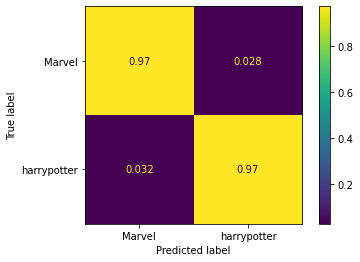

In [36]:
ConfusionMatrixDisplay.from_estimator(gs1, X_test, y_test, normalize='pred');

In [39]:
f1_score(y_test, gs1.predict(X_test), pos_label='harrypotter')

0.9771986970684039

In [41]:
balanced_accuracy_score(y_test, gs1.predict(X_test))

0.9665314150559122